# Link shapes within a property extent

AddressBase Plus (AB+) contians UPRNs of properties and the building TopographicArea TOID that they relate to. It does not cointain the other shapes that may also be associated with that property, such as the gardens and paths.

- use AB+ to identify residential dwellings in the 1980 1 km grid
- use TopoArea 1980 cut and make representative point for each Building, Land, path shape 
- use Land Registry polygons to enclose and tag each shape whose representative point lies within
- select private garden shapes that are coincident (intersect) with roasdside shapes


## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import mplleaflet
import folium
import fiona
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

from rasterio._base import gdal_version
import rasterio
import contextily
import shapely as shp

In [2]:
#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Load AddressBase Plus 1980 points file

In [3]:
abp1980_path = "../data/addressBasePlus1980/addressBasePlus1980.gpkg"

In [4]:
for layername in fiona.listlayers(abp1980_path):
    with fiona.open(abp1980_path, layer=layername) as src:
        print(layername, len(src))

addressBasePlus1980 4418


In [5]:
abp1980 = gpd.read_file(abp1980_path)

### Create new column ta_topo_toid to match TOID in TopoArea format
- osgb must be stripped out
- toid strings padded to 16 characters with 000 at the front

In [6]:
#find length of each toid string and count number of rows of each length
abp1980.os_topo_toid.str.len().value_counts()

17    3899
20     519
Name: os_topo_toid, dtype: int64

In [7]:
abp1980['ta_topo_toid'] = np.where(
    (abp1980.os_topo_toid.str.len() == 17),
    abp1980.os_topo_toid.str.replace('osgb','000', regex=True),
    abp1980.os_topo_toid.str.replace('osgb','', regex=True)
)
#this appears to work but I get a warning about slice/copies of data

In [8]:
abp1980.head()

,ogc_fid,uprn,udprn,change_type,state,state_date,class,parent_uprn,x_coordinate,y_coordinate,latitude,longitude,rpc,local_custodian_code,country,la_start_date,last_update_date,entry_date,rm_organisation_name,la_organisation,department_name,legal_name,sub_building_name,building_name,building_number,sao_start_number,sao_start_suffix,sao_end_number,sao_end_suffix,sao_text,alt_language_sao_text,pao_start_number,pao_start_suffix,pao_end_number,pao_end_suffix,pao_text,alt_language_pao_text,usrn,usrn_match_indicator,area_name,level,official_flag,os_address_toid,os_address_toid_version,os_roadlink_toid,os_roadlink_toid_version,os_topo_toid,os_topo_toid_version,voa_ct_record,voa_ndr_record,street_description,alt_language_street_description,dependent_thoroughfare,thoroughfare,welsh_dependent_thoroughfare,welsh_thoroughfare,double_dependent_locality,dependent_locality,locality,welsh_dependent_locality,welsh_double_dependent_locality,town_name,administrative_area,post_town,welsh_post_town,postcode,postcode_locator,postcode_type,delivery_point_suffix,addressbase_postal,po_box_number,ward_code,parish_code,rm_start_date,multi_occ_count,voa_ndr_p_desc_code,voa_ndr_scat_code,alt_language,geometry,ta_topo_toid
0,296806,10025192401,NaN,I,NaN,None,CU01,NaN,519956.15,180778.50,51.513208,-0.272704,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION AT 42 JULIAN AVENUE 18...,,20600958,2,,,N,osgb5000000001197892,7.0,osgb4000000030134752,4,osgb1000003511413,2,NaN,NaN,JULIAN AVENUE,,,,,,,,,,,ACTON,EALING,,,,W3 9JF,,,N,,E05000170,,None,0,,,,POINT (519956.150 180778.500),0001000003511413
1,305783,10025172223,NaN,I,NaN,None,CU11,NaN,519834.90,180341.70,51.509308,-0.274599,1,7655,E,2011-09-16,2019-06-02,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,PUBLIC TELEPHONE 28M FROM 14 BARLOW ROAD 7M FR...,,20601052,2,,,N,osgb5000000001202676,9.0,osgb4000000030406668,3,osgb1000001778708757,7,NaN,NaN,LEXDEN ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9LJ,,,N,,E05000188,,None,0,,,,POINT (519834.900 180341.700),1000001778708757
2,318096,10025172224,NaN,I,NaN,None,CT02,NaN,519633.71,180227.30,51.508322,-0.277536,1,7655,E,2011-09-16,2019-01-27,2016-01-15,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,"SHELTER 14M FROM NORTH CHINA RESTAURANT, 305 U...",,20602318,2,,,N,osgb5000000001202678,21.0,osgb4000000030700979,4,osgb1000003512425,4,NaN,NaN,UXBRIDGE ROAD,,,,,,,,,,,ACTON,EALING,,,,W3 9QU,,,N,,E05000188,,None,0,,,,POINT (519633.710 180227.300),0001000003512425
3,327086,10025191384,NaN,I,NaN,None,CU01,NaN,519304.50,180218.50,51.508312,-0.282280,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 9M FROM 377 UXBRIDGE R...,,20600982,2,,,N,osgb5000000001199570,11.0,osgb4000000030214874,7,osgb1000001778713708,4,NaN,NaN,KING EDWARDS GARDENS,,,,,,,,,,,ACTON,EALING,,,,W3 9RH,,,N,,E05000188,,None,0,,,,POINT (519304.500 180218.500),1000001778713708
4,327308,10025192403,NaN,I,NaN,None,CU01,NaN,519009.85,180705.63,51.512753,-0.286360,1,7655,E,2011-09-16,2020-01-04,2018-11-27,,,,,,,NaN,NaN,,NaN,,,,NaN,,NaN,,ELECTRICITY SUB STATION 22M FROM 2 DANIEL ROAD...,,20600509,2,,,N,osgb5000000001197896,11.0,osgb4000000030215303,6,osgb1000001778685560,6,NaN,NaN,DANIEL ROAD,,,,,,,,,,,EALING,EALING,,,,W5 3RY,,,N,,E05000188,,None,0,,,,POINT (519009.850 180705.630),1000001778685560


## Apply filters

Residential dwellings
- RD      Dwelling
- RD01	Caravan
- RD02	Detached
- RD03	Semi-Detached
- RD04	Terraced
- RD06	Self Contained Flat (Includes Maisonette / Apartment)
- RD07	House Boat
- RD08	Sheltered Accommodation
- RD10	Privately Owned Holiday Caravan / Chalet

Residential garage - look at these later
- RG	Garage
- RG02	Lock-Up Garage / Garage Court

In [9]:
#create RD filter mask
rdmask = abp1980['class'].str.startswith("RD")
#apply filter mask
rdabp1980 = abp1980[rdmask]
#count RD values
rdabp1980['class'].value_counts()

RD06    2465
RD03     741
RD04     196
RD02      87
RD08      84
RD         5
Name: class, dtype: int64

### Check unique UPRNs 

Within the set of residential dwellings

In [10]:
#count values of uprn
rdabp1980.uprn.value_counts()

12148848    1
12180098    1
12131528    1
12095141    1
12008094    1
           ..
12094763    1
12168788    1
12156201    1
12094759    1
12175361    1
Name: uprn, Length: 3578, dtype: int64

In [11]:
rdabp1980.head()

,ogc_fid,uprn,udprn,change_type,state,state_date,class,parent_uprn,x_coordinate,y_coordinate,latitude,longitude,rpc,local_custodian_code,country,la_start_date,last_update_date,entry_date,rm_organisation_name,la_organisation,department_name,legal_name,sub_building_name,building_name,building_number,sao_start_number,sao_start_suffix,sao_end_number,sao_end_suffix,sao_text,alt_language_sao_text,pao_start_number,pao_start_suffix,pao_end_number,pao_end_suffix,pao_text,alt_language_pao_text,usrn,usrn_match_indicator,area_name,level,official_flag,os_address_toid,os_address_toid_version,os_roadlink_toid,os_roadlink_toid_version,os_topo_toid,os_topo_toid_version,voa_ct_record,voa_ndr_record,street_description,alt_language_street_description,dependent_thoroughfare,thoroughfare,welsh_dependent_thoroughfare,welsh_thoroughfare,double_dependent_locality,dependent_locality,locality,welsh_dependent_locality,welsh_double_dependent_locality,town_name,administrative_area,post_town,welsh_post_town,postcode,postcode_locator,postcode_type,delivery_point_suffix,addressbase_postal,po_box_number,ward_code,parish_code,rm_start_date,multi_occ_count,voa_ndr_p_desc_code,voa_ndr_scat_code,alt_language,geometry,ta_topo_toid
13,955130,12007532,25798588.0,I,NaN,None,RD06,12125401.0,519986.0,179990.0,51.506115,-0.272543,2,5270,E,2007-12-27,2018-12-09,2001-08-10,,,,,FLAT 21,BARRINGTON COURT,24.0,21.0,,NaN,,,,24.0,,NaN,,BARRINGTON COURT,,20600359,1,,,Y,osgb1000002229451550,8.0,osgb4000000030322209,3,osgb1000003509225,8,430810081.0,NaN,CHELTENHAM PLACE,,,CHELTENHAM PLACE,,,,,,,,ACTON,EALING,LONDON,,W3 8JT,W3 8JT,S,5H,D,,E05000188,,2012-03-19,0,,,,POINT (519986.000 179990.000),0001000003509225
14,955131,12007544,25798601.0,I,NaN,None,RD06,12125401.0,519986.0,179990.0,51.506115,-0.272543,2,5270,E,2007-12-27,2018-12-09,2001-08-10,,,,,FLAT 33,BARRINGTON COURT,24.0,33.0,,NaN,,,,24.0,,NaN,,BARRINGTON COURT,,20600359,1,,,Y,osgb1000002229451519,8.0,osgb4000000030322209,3,osgb1000003509225,8,430822081.0,NaN,CHELTENHAM PLACE,,,CHELTENHAM PLACE,,,,,,,,ACTON,EALING,LONDON,,W3 8JT,W3 8JT,S,5Y,D,,E05000188,,2012-03-19,0,,,,POINT (519986.000 179990.000),0001000003509225
15,955132,12007561,25798620.0,I,NaN,None,RD06,12125401.0,519986.0,179990.0,51.506115,-0.272543,2,5270,E,2007-12-27,2018-12-09,2001-08-10,,,,,FLAT 50,BARRINGTON COURT,24.0,50.0,,NaN,,,,24.0,,NaN,,BARRINGTON COURT,,20600359,1,,,Y,osgb1000002229451569,8.0,osgb4000000030322209,3,osgb1000003509225,8,430839081.0,NaN,CHELTENHAM PLACE,,,CHELTENHAM PLACE,,,,,,,,ACTON,EALING,LONDON,,W3 8JT,W3 8JT,S,6U,D,,E05000188,,2012-03-19,0,,,,POINT (519986.000 179990.000),0001000003509225
16,955137,12007792,25798510.0,I,NaN,None,RD06,12125405.0,519892.0,180004.0,51.506260,-0.273892,2,5270,E,2007-12-27,2018-09-23,2001-08-10,,,,,FLAT 23,ARLINGTON COURT,17.0,23.0,,NaN,,,,17.0,,NaN,,ARLINGTON COURT,,20601183,1,,,Y,osgb1000002298383129,8.0,osgb4000000030322189,5,osgb1000003512748,8,430311081.0,NaN,MILL HILL ROAD,,,MILL HILL ROAD,,,,,,,,ACTON,EALING,LONDON,,W3 8JP,W3 8JP,S,3T,D,,E05000188,,2012-03-19,0,,,,POINT (519892.000 180004.000),0001000003512748
17,955138,12007814,25798533.0,I,NaN,None,RD06,12125405.0,519892.0,180004.0,51.506260,-0.273892,2,5270,E,2007-12-27,2018-09-23,2001-08-10,,,,,FLAT 44,ARLINGTON COURT,17.0,44.0,,NaN,,,,17.0,,NaN,,ARLINGTON COURT,,20601183,1,,,Y,osgb1000002298383142,8.0,osgb4000000030322189,5,osgb1000003512748,8,430332081.0,NaN,MILL HILL ROAD,,,MILL HILL ROAD,,,,,,,,ACTON,EALING,LONDON,,W3 8JP,W3 8JP,S,2Q,D,,E05000188,,2012-03-19,0,,,,POINT (519892.000 180004.000),0001000003512748


In [12]:
rdabp1980.ta_topo_toid.str.len().value_counts()

16    3578
Name: ta_topo_toid, dtype: int64

In [13]:
rdabp1980.ta_topo_toid.value_counts()
#so presumably the counts greater than 1 are blocks of flats, where the same building 
#shape is associated with many addresses

0001000003512688    100
5000005103566383     85
0001000003512748     66
0001000003509225     63
0001000003512681     50
                   ... 
0001000003513326      1
0001000003512243      1
0001000003511362      1
0001000003511929      1
0001000003513328      1
Name: ta_topo_toid, Length: 1550, dtype: int64

In [14]:
rdabp1980.shape

(3578, 80)

## Density plot

Do a density plot of the points - since some UPRNs have the same building shape (blocks of flats). Want to see where these are. Make marksize according to the number of UPRNs associated with each TOID. Although note in AB+ that there may be more than 1 point for a TOID, presumably to mark the different wings of a block of flats.   

In [15]:
#select just toid and point
rd_toids = rdabp1980[['ta_topo_toid', 'geometry']]
#drop dupes
rd_toids = rd_toids.drop_duplicates()
#sort by toid
rd_toids = rd_toids.sort_values(by = ['ta_topo_toid'])
#check
rd_toids.head()

,ta_topo_toid,geometry
760,0001000003410339,POINT (518991.000 180654.000)
3260,0001000003410581,POINT (518989.000 180904.000)
621,0001000003410583,POINT (518983.000 180858.000)
761,0001000003410584,POINT (518996.000 180854.000)
626,0001000003410744,POINT (518999.000 180543.000)


In [16]:
#collect value_counts from parent df, make df and sort
rd_toid_counts = rdabp1980.ta_topo_toid.value_counts().rename_axis('ta_topo_toid').reset_index(name = 'count').sort_values(by = 'ta_topo_toid')


In [17]:
rd_toid_counts.head()

,ta_topo_toid,count
1035,0001000003410339,1
178,0001000003410581,4
59,0001000003410583,7
125,0001000003410584,4
707,0001000003410744,1


In [18]:
#join counts
rd_toids = rd_toids.set_index('ta_topo_toid').join(rd_toid_counts.set_index('ta_topo_toid'))

In [19]:
rd_toids.sort_values(by = ['count'])

,geometry,count
ta_topo_toid,,
0001000003410339,POINT (518991.000 180654.000),1
0001000003512148,POINT (519796.000 180215.000),1
0001000003513324,POINT (519312.000 180315.000),1
0001000003512150,POINT (519807.000 180213.000),1
0001000003513323,POINT (519299.000 180316.000),1
...,...,...
0001000003512748,POINT (519892.000 180004.000),66
5000005103566383,POINT (519658.000 180182.000),85
5000005103566383,POINT (519668.000 180176.000),85


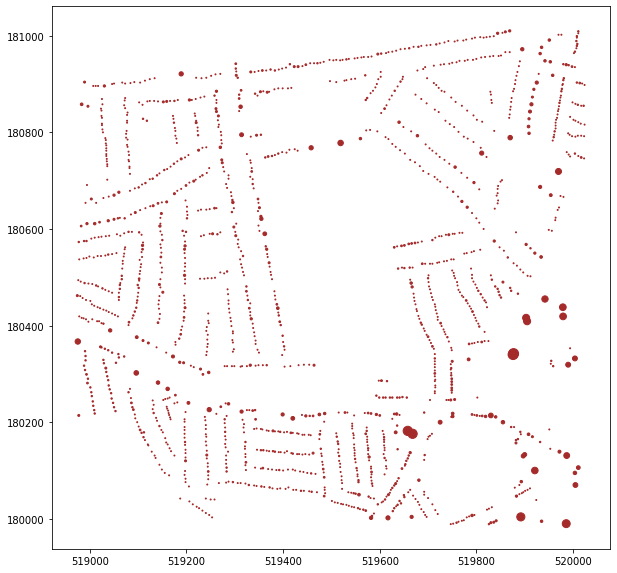

In [20]:
rd_toids.plot(figsize=(10,10), color = 'brown', markersize='count')
#so clearly there are some blocks of flats - weirdly though the same TopoArea toid has more than one point
#associated with it in this dataset - maybe this is a distinct block?

## Load eTopoArea_1980 file

In [21]:
path = "../data/eTopoArea_1980/eTopoArea_1980.gpkg"
for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
        
ta = gpd.read_file(path)

eTopoArea_1980 7200


In [22]:
#reduce to just Theme == Land or Buildings
talb = ta.query('Theme == "Land" | Theme == "Buildings"')

### Look at just RD04 terraced residential dwellings

- looks like these are remaining single dwelling houses that are terraces
- terraced and other housing split into maisonettes/apartments is in RD06

In [23]:
#get list of RD4 toids from abp1980

In [ ]:
#create RD04 filter mask
rd04mask = abp1980['class'].str.startswith("RD04")
#apply filter mask
rd04 = abp1980[rd04mask]

In [ ]:
rd04list = rd04['ta_topo_toid'].tolist()

In [ ]:
len(rd04list)

In [ ]:
ta_rd04 = ta[ta['TOID'].isin(rd04list)]


In [ ]:
ta_rd04.shape

In [ ]:
base = ta_rd04.plot(figsize=(10,10), color = 'green')
rd04.plot(color = 'yellow', ax = base, markersize = 3)

## Look at all RD residential dwelling building topos 

In [24]:
#get UPRN topo toid list
toid_list = rd_toid_counts['ta_topo_toid'].tolist()

In [26]:
len(toid_list)

1550

In [27]:
ta_rd = ta[ta['TOID'].isin(toid_list)]

In [28]:
ta_rd.shape

(1585, 23)

In [29]:
ta_rd.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
12,643653,643653,0001000003512755,10021,9,2015-01-15T00:00:00,Buildings,1,66.834319,2015-01-11T00:00:00,Modified,4,Building,1,None,NaN,Manmade,50,None,false,40.986021,66.834319,"POLYGON ((519782.450 180013.100, 519784.650 18..."
18,643659,643659,1000001778783957,10021,6,2008-03-18T00:00:00,Buildings,1,287.886040,2002-01-24T00:00:00,New,1,Building,1,None,NaN,Manmade,50,None,false,75.707951,287.886050,"POLYGON ((519663.510 180013.930, 519664.570 18..."
71,644898,644898,0001000003509166,10021,7,2020-01-31T00:00:00,Buildings,1,88.279200,2020-01-31T00:00:00,Modified,2,Building,1,None,NaN,Manmade,50,None,false,42.890179,88.279199,"POLYGON ((519756.950 179987.750, 519752.000 17..."
134,646612,646612,0001000003509185,10021,3,2008-03-18T00:00:00,Buildings,1,64.857512,1993-05-01T00:00:00,Reclassified,1,Building,1,None,NaN,Manmade,50,None,false,36.880204,64.857500,"POLYGON ((519825.100 179980.900, 519820.300 17..."
147,646628,646628,0001000003512201,10021,9,2015-01-15T00:00:00,Buildings,1,54.315000,2015-01-11T00:00:00,Restructured,4,Building,1,None,NaN,Manmade,50,None,false,30.767529,54.315525,"POLYGON ((519692.850 180003.600, 519699.300 18..."


In [30]:
#check length of toid strings here
ta_rd.TOID.str.len().value_counts()

16    1585
Name: TOID, dtype: int64

In [32]:
ta_rd.nunique()

id                       1585
OBJECTID                 1585
TOID                     1550
FeatureCode                 2
Version                    12
VersionDate                45
Theme                       2
ThemeCount                  1
CalculatedAreaValue      1549
ChangeDate                 62
ReasonForChange             7
ChangeHistoryCount          8
DescriptiveGroup            2
DescriptiveGroupCount       1
DescriptiveTerm             0
DescriptiveTermCount        0
Make                        2
PhysicalLevel               1
PhysicalPresence            0
broken                      1
SHAPE_Length             1550
SHAPE_Area               1550
geometry                 1550
dtype: int64

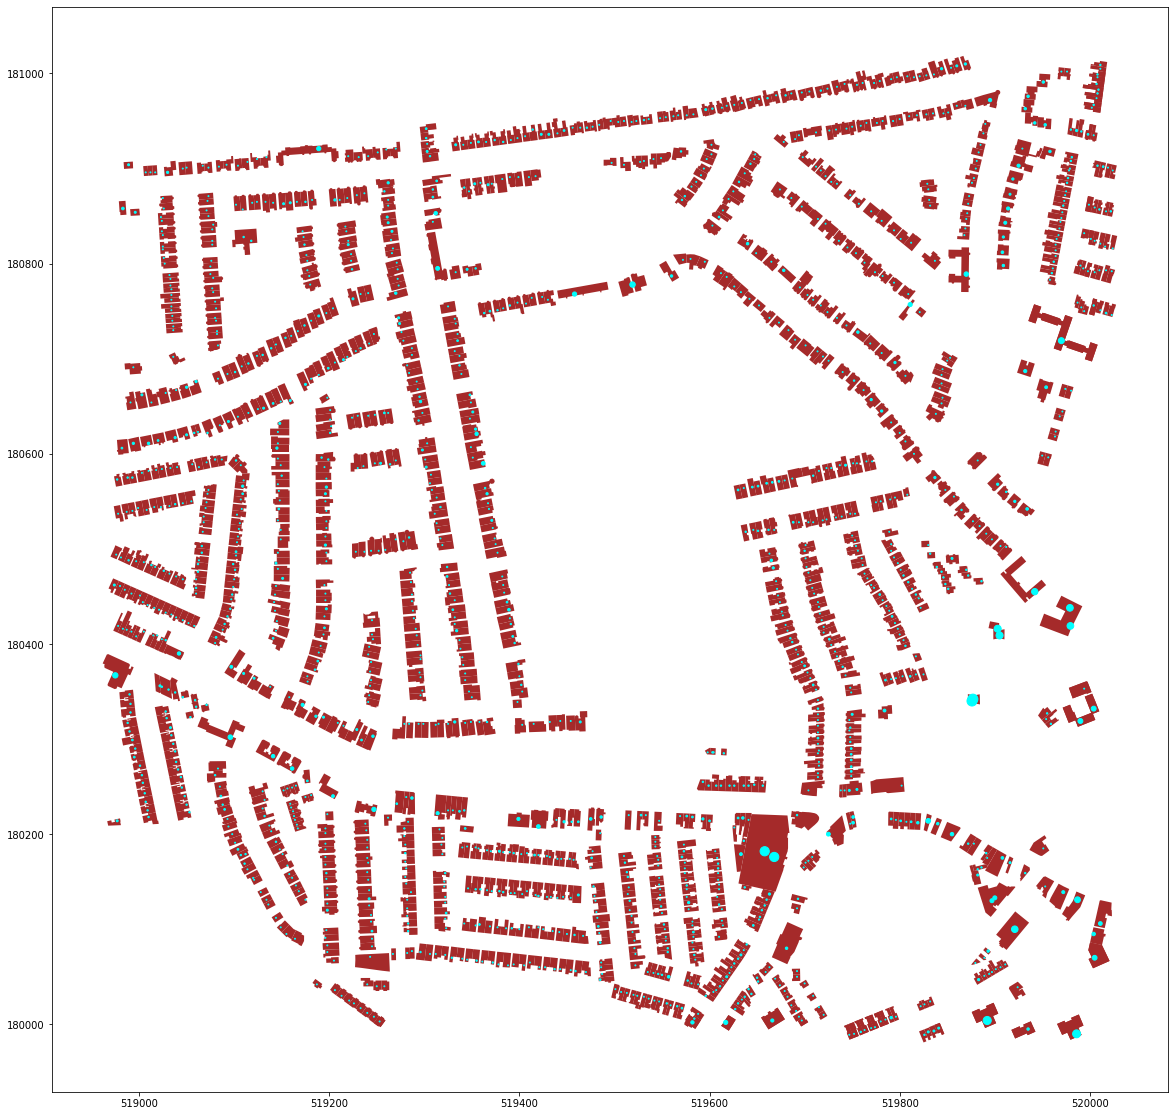

In [33]:
base = ta_rd.plot(figsize=(20,20), color = 'brown')
rd_toids.plot(figsize=(20,20), color = 'cyan', markersize='count', ax = base)


## Select private gardens adjacent to buildings and roadside 

https://geopandas.org/reference/geopandas.overlay.html

- select Land TOIDs that adjunct to Roadside and Building TOIDS
- use intersects or touches

- ta_rd object is the gdf of the buildings that are residential dwellings

### Create gdf of private gardens in 1980 grid

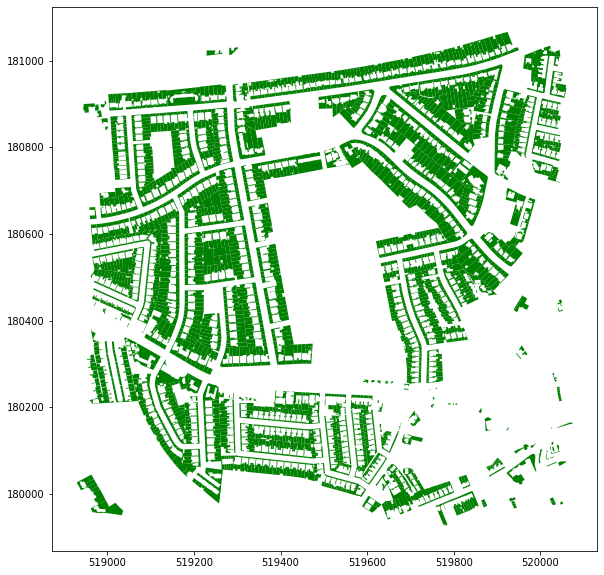

In [34]:
#Using SK filters from dft-demo code
#this seems to remove any shared gardens
ta_gdn = ta.query(
    'DescriptiveGroup == "General Surface" & DescriptiveTerm == "Multi Surface" & Make == "Multiple"')

ta_gdn.plot(figsize = (10,10), color = 'green')

### Spatial join private gardens with residential dwellings

- use gpd.sjoin(gdf1, gdf2, how = 'inner', op = 'intersects')
- keeps geometries of gdf1 that intersect with geometries of gdf2

In [35]:
#gdn_rd: gardens of residential dwellings 
gdn_rd = gpd.sjoin(ta_gdn, ta_rd, how = 'inner', op = 'intersects')

In [36]:
print("Number of private gardens: ", ta_gdn.shape[0])
print("Number of private gardens interesecting with residential dwellings in 1980 grid: ", gdn_rd.shape[0])

Number of private gardens:  2723
Number of private gardens interesecting with residential dwellings in 1980 grid:  5033


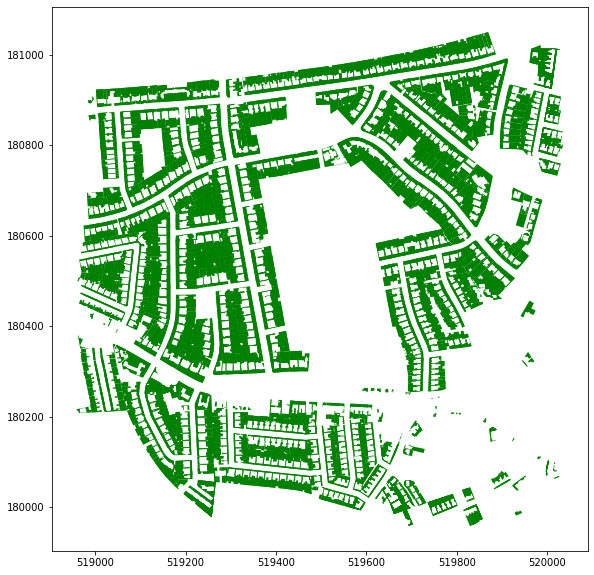

In [37]:
#I think all we lose here are private gardens whose building is not in this grid
#we also gain duplicates since a private garden may intersect with more than one residential dwelling
#where the residential dwellings all occupy the same physical building - as in flats
gdn_rd.plot(figsize = (10,10), color = 'green')

### Check value counts

We get multiple instances of garden TOIDs and residential dwelling TOIDs

In [38]:
gdn_rd.TOID_left.value_counts()

1000001778697704    12
1000001778697710    12
1000001778708452    12
1000001778697706    12
1000001778783950    10
                    ..
1000001778701800     1
5000005138038764     1
1000001778714256     1
1000001778714191     1
1000001778697732     1
Name: TOID_left, Length: 2445, dtype: int64

In [39]:
gdn_rd.TOID_right.value_counts()

0001000042005581    18
0001000042005576    18
1000001785022022    18
0001000042005578    18
0001000003512166    18
                    ..
0001000003513042     1
0001000003410583     1
0001000003513362     1
0001000003511879     1
0001000003511321     1
Name: TOID_right, Length: 1502, dtype: int64

### Check a duplicated garden TOID

In [40]:
chk = gdn_rd.query('TOID_left == "1000001778697706"')

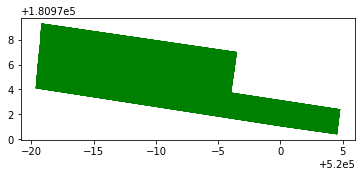

In [41]:
chk.plot(color = 'green')
#this is a garden shape

In [42]:
chk.TOID_left.value_counts()

1000001778697706    12
Name: TOID_left, dtype: int64

In [43]:
print(chk.shape)
#check building toids
chk.TOID_right.value_counts()
#3 different buildings
#each must intersect with 4 gardens?

(12, 46)


0001000042005579    4
0001000042005580    4
0001000042005581    4
Name: TOID_right, dtype: int64

In [44]:
chk.index_right.value_counts()
#collect these building from ta_rd and plot

7164    2
7163    2
7162    2
6467    2
6466    2
6465    2
Name: index_right, dtype: int64

In [45]:
blist = chk.TOID_right.value_counts().index


In [46]:
chk_b = ta_rd[ta_rd['TOID'].isin(blist)]


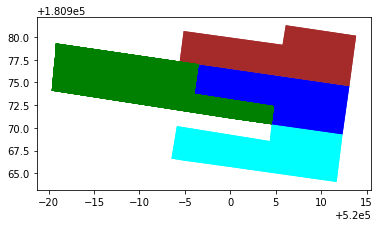

In [47]:
base = chk_b.query('TOID == "0001000042005581"').plot(color = 'cyan')
chk_b.query('TOID == "0001000042005580"').plot(ax = base,color = 'blue')
chk_b.query('TOID == "0001000042005579"').plot(ax = base,color = 'brown')
chk.plot(ax = base, color = "green")
#three buildings all intersecting with the garden (green) shape
#3 buildings, but 4 residences for each!
#clearly 'intersect' includes point intersection as only the corners of the bottom building and the garden touch

In [48]:
chk_b

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
6465,841706,841706,0001000042005581,10021,7,2014-12-10T00:00:00,Buildings,1,78.442956,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,47.376615,78.442957,"POLYGON ((520012.350 180969.300, 520011.700 18..."
6466,841707,841707,0001000042005580,10021,7,2014-12-10T00:00:00,Buildings,1,71.945200,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,44.174960,71.945200,"POLYGON ((520013.100 180974.600, 520012.350 18..."
6467,841708,841708,0001000042005579,10021,7,2014-12-10T00:00:00,Buildings,1,81.752781,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,48.853776,81.752782,"POLYGON ((520013.850 180980.150, 520013.100 18..."
7162,1306954,1306954,0001000042005581,10021,7,2014-12-10T00:00:00,Buildings,1,78.442956,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,47.376615,78.442957,"POLYGON ((520012.350 180969.300, 520011.700 18..."
7163,1306955,1306955,0001000042005580,10021,7,2014-12-10T00:00:00,Buildings,1,71.945200,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,44.174960,71.945200,"POLYGON ((520013.100 180974.600, 520012.350 18..."
7164,1306956,1306956,0001000042005579,10021,7,2014-12-10T00:00:00,Buildings,1,81.752781,2014-12-09T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,48.853776,81.752782,"POLYGON ((520013.850 180980.150, 520013.100 18..."


In [49]:
ta_rd.shape

(1585, 23)

In [50]:
ta_gdn.shape

(2723, 23)

In [51]:
gdn_rd.shape

(5033, 46)

In [52]:
gdn_rd.head()

,id_left,OBJECTID_left,TOID_left,FeatureCode_left,Version_left,VersionDate_left,Theme_left,ThemeCount_left,CalculatedAreaValue_left,ChangeDate_left,ReasonForChange_left,ChangeHistoryCount_left,DescriptiveGroup_left,DescriptiveGroupCount_left,DescriptiveTerm_left,DescriptiveTermCount_left,Make_left,PhysicalLevel_left,PhysicalPresence_left,broken_left,SHAPE_Length_left,SHAPE_Area_left,geometry,index_right,id_right,OBJECTID_right,TOID_right,FeatureCode_right,Version_right,VersionDate_right,Theme_right,ThemeCount_right,CalculatedAreaValue_right,ChangeDate_right,ReasonForChange_right,ChangeHistoryCount_right,DescriptiveGroup_right,DescriptiveGroupCount_right,DescriptiveTerm_right,DescriptiveTermCount_right,Make_right,PhysicalLevel_right,PhysicalPresence_right,broken_right,SHAPE_Length_right,SHAPE_Area_right
11,643285,643285,1000001778707998,10053,8,2019-11-04T00:00:00,Land,1,42.279625,2019-11-01T00:00:00,Modified,4,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,26.276497,42.279625,"POLYGON ((519570.241 180005.007, 519568.750 18...",4946,824723,824723,0001000003512270,10021,6,2019-11-04T00:00:00,Buildings,1,84.15066,2019-11-01T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,46.801038,84.15066
80,644935,644935,1000001778708000,10053,8,2019-11-04T00:00:00,Land,1,101.016240,2019-11-01T00:00:00,Modified,5,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17...",4946,824723,824723,0001000003512270,10021,6,2019-11-04T00:00:00,Buildings,1,84.15066,2019-11-01T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,46.801038,84.15066
95,646509,646509,1000001778708005,10053,8,2014-05-29T00:00:00,Land,1,58.462100,2014-04-29T00:00:00,Modified,4,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,41.588345,58.462100,"POLYGON ((519562.750 180000.000, 519562.500 17...",4946,824723,824723,0001000003512270,10021,6,2019-11-04T00:00:00,Buildings,1,84.15066,2019-11-01T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,46.801038,84.15066
229,817271,817271,1000001778707998,10053,8,2019-11-04T00:00:00,Land,1,42.279625,2019-11-01T00:00:00,Modified,4,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,26.276497,42.279625,"POLYGON ((519570.241 180005.007, 519568.750 18...",4946,824723,824723,0001000003512270,10021,6,2019-11-04T00:00:00,Buildings,1,84.15066,2019-11-01T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,46.801038,84.15066
230,817272,817272,5000005254476709,10053,1,2019-11-04T00:00:00,Land,1,5.456929,2019-11-01T00:00:00,New,1,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,9.538472,5.456928,"POLYGON ((519571.536 180009.445, 519569.845 18...",4946,824723,824723,0001000003512270,10021,6,2019-11-04T00:00:00,Buildings,1,84.15066,2019-11-01T00:00:00,Modified,3,Building,1,None,NaN,Manmade,50,None,false,46.801038,84.15066


### Tidy gdn_rd

Gardens with residential dwellings has lots of duplicates and unecessary information at this point, also all the column names have been changed with _left or _right appended. 

- take list of TOIDS from sjoin
- filter ta_gdn

so I have my original, unduplicated gdf, with just the garden TOIDs that intersect with at least one residential dwelling.

In [53]:
gdn_toids = gdn_rd['TOID_left'].drop_duplicates().tolist()

In [54]:
gdn_toids

['1000001778707998',
 '1000001778708000',
 '1000001778708005',
 '5000005254476709',
 '1000001778708878',
 '5000005125902285',
 '1000001778708232',
 '1000001778708231',
 '1000001778783950',
 '1000001778708532',
 '1000001778707982',
 '1000001778708052',
 '1000001778708454',
 '1000001778708452',
 '1000001793586593',
 '1000001793586592',
 '1000001793586591',
 '1000001778708453',
 '1000001793586664',
 '1000001778708313',
 '1000001778708314',
 '1000001793587072',
 '1000001778708320',
 '1000001778708321',
 '1000001778708312',
 '1000001778708316',
 '5000005139938936',
 '1000001778708318',
 '1000001793586595',
 '1000001793586594',
 '1000001778708464',
 '1000001793586993',
 '1000001793586990',
 '1000001778708351',
 '1000001793586988',
 '1000001793586997',
 '1000001793586992',
 '1000001793586981',
 '1000001793586983',
 '1000001778708319',
 '1000001778708315',
 '1000001778708323',
 '1000001778708617',
 '1000001778708317',
 '1000001778707987',
 '1000001778707985',
 '5000005139938876',
 '10000017787

In [55]:
len(gdn_toids)

2445

In [56]:
gdn = ta_gdn[ta_gdn['TOID'].isin(gdn_toids)]


In [57]:
print(ta_gdn.shape)
print(gdn.shape)

(2723, 23)
(2492, 23)


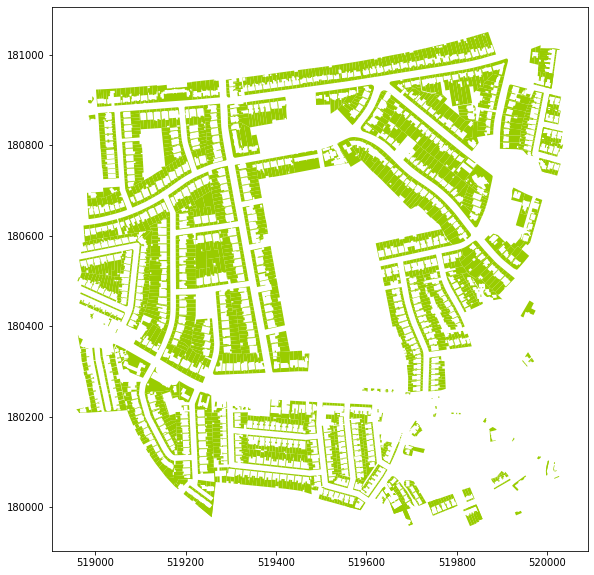

In [58]:
gdn.plot(figsize=(10,10), color = '#99cc00')

(180800, 181000)

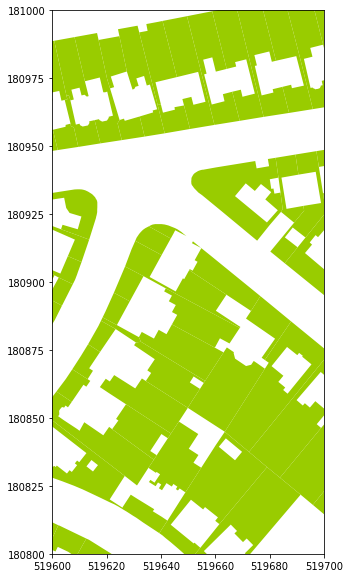

In [59]:
base = gdn.plot(figsize=(10,10), color = '#99cc00')
base.set_xlim(519600,519700)
base.set_ylim(180800,181000)

### Spatial join with roadside

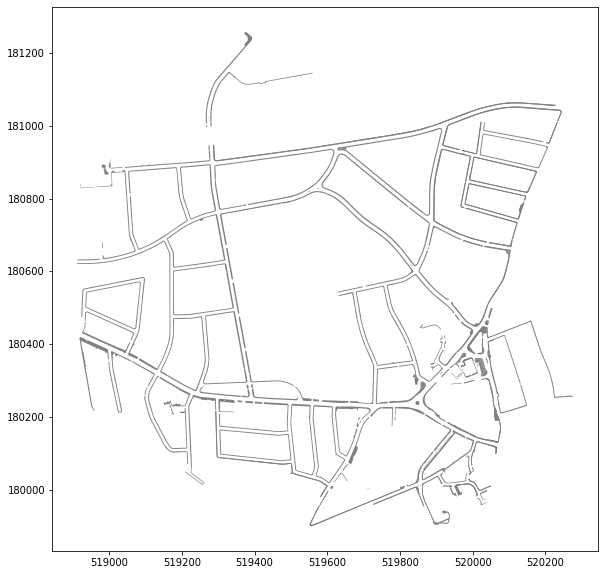

In [60]:
#create gdf of roadside objects ta_rs (topographic area roadside)
ta_rs = ta.query('DescriptiveGroup == "Roadside"')
ta_rs.plot(figsize = (10,10), color = 'grey')

In [61]:
#Spatial join; inner; intersects
#keep LHS gdf geometries that intersect with RHS geometries
#keep RHS information too, but not the geometries, so rows may increase
rs_gdn = gpd.sjoin(gdn, ta_rs, how = 'inner', op = 'intersects')

In [62]:
rs_gdn.shape

(1941, 46)

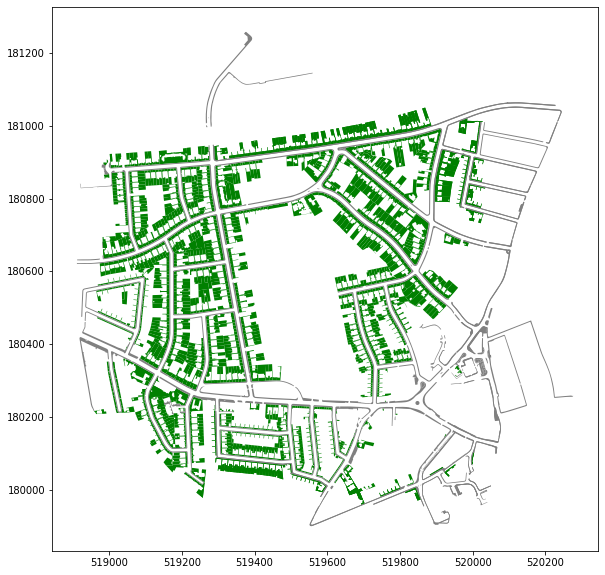

In [63]:
base = rs_gdn.plot(figsize = (10,10), color = 'green')
ta_rs.plot(ax=base, color = 'grey') #checking hasn't merged pavements to gardens

In [64]:
#get list of unique TOIDs
rs_gdn_toids = rs_gdn['TOID_left'].drop_duplicates().tolist()
len(rs_gdn_toids)

1596

In [66]:
#filter from original df to get names back and remove duplicates
rs_gdn = ta_gdn[ta_gdn['TOID'].isin(rs_gdn_toids)]

In [67]:
rs_gdn.shape
#was expecting this to be 1596, guess some of these TOIDs are repeated

(1624, 23)

In [70]:
rs_gdn.geometry.name

'geometry'

(180900, 181100)

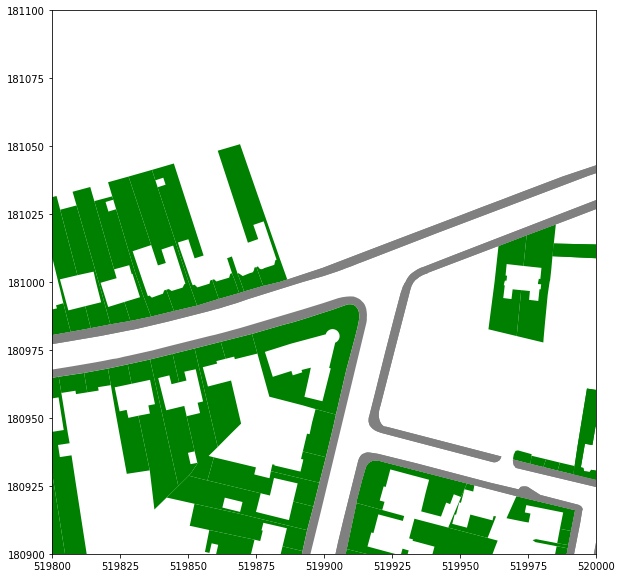

In [71]:
base = rs_gdn.plot(figsize = (10,10), color = 'green')
ta_rs.plot(ax=base, color = 'grey') #checking hasn't merged pavements to gardens
base.set_xlim(519800,520000)
base.set_ylim(180900,181100)

### Drop polygons that are too small by area - leave for now

Probably should do this earlier. But it's crude, small cars may fit in spaces smaller than standard

Standard size parking bay is 2.4 by 4.8 metres which is 11.52 square metres.
And perimeter is 14.4 m. Not sure if this is useful...

Obviously the shape of the space matters...

This only drops about 20 shapes from this list, and not even the troublesome ones...

In [72]:
rs_gdn = rs_gdn.set_geometry('geometry')
rs_gdn2 = rs_gdn.query('SHAPE_Area > 11.52')

(180000, 180200)

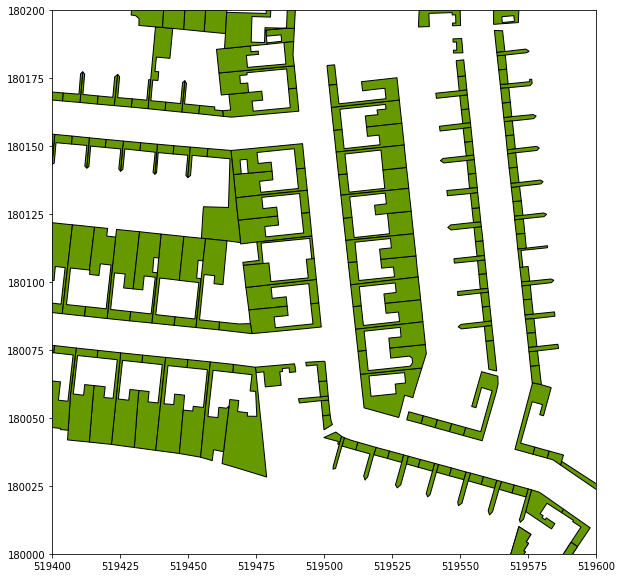

In [73]:
base = rs_gdn2.plot(figsize = (10,10), color = '#669900', edgecolor = 'black')
base.set_xlim(519400,519600)
base.set_ylim(180000,180200)

In [74]:
rs_gdn2.shape
#only lost about 20 - so let's not bother!

(1609, 23)

In [75]:
2.4*4.8

11.52

### Check sizes of gdfs are reducing

In [68]:
print("Number of private gardens: ", ta_gdn.shape[0] )
print("Number of roadside private gardens: ", rs_gdn.shape[0])
print("Number of roadside private gardens adjacent to houses: ", rs_gdn.shape[0])

Number of private gardens:  2723
Number of roadside private gardens:  1941
Number of roadside private gardens adjacent to houses:  1941


## Intersect with buffer zone of a pavement shape

Take the intersection of the pavement buffer and the shape, keeping the garden shape information. The purpose of this is to chop off the front section of a garden that extends to the rear via aside alley in a detatched or semi-detatched proporty.

Had a look at this and I don't think it will work. I can't set the buffer size to a fixed distance that will work for all, and the buffer would need to be quite deep anyway, which on a narrow road/pavement would risk intersecting with garden shapes from the opposite side of the road. 

In [86]:
#create dataset of pavement shapes with buffer of say 5m
ta_rsbuff = ta.query('DescriptiveGroup == "Roadside"').geometry.buffer(4)
#ta_rsbuff['geometry'] = ta_rsbuff.geometry.buffer(5) #BNG is in metres so buffer distance is also

(180900, 181000)

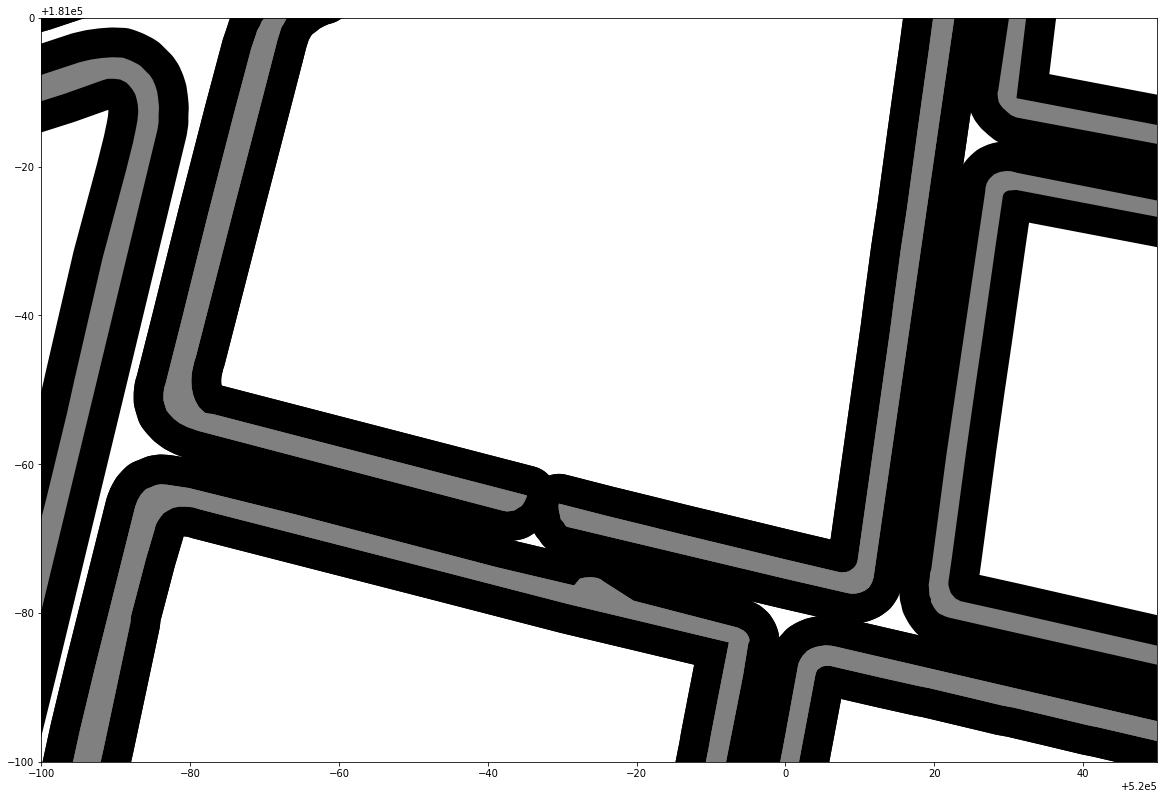

In [107]:
base = ta_rsbuff.plot(figsize=(20,20), color = 'black')
ta_rs.plot(ax = base, color = 'grey')
base.set_xlim(519900,520050)
base.set_ylim(180900,181000)

In [70]:
ta_rsbuff.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
49,644766,644766,1000001778708368,10183,12,2016-10-19T00:00:00,Roads Tracks And Paths,1,964.537417,2016-10-19T00:00:00,Modified,11,Roadside,1,None,NaN,Manmade,50,None,false,789.659862,964.537416,"POLYGON ((519812.541 180008.395, 519811.356 18..."
82,644937,644937,5000005139937478,10183,2,2019-11-04T00:00:00,Roads Tracks And Paths,1,487.812248,2019-11-01T00:00:00,Restructured,2,Roadside,1,None,NaN,Manmade,50,None,false,373.008633,487.815113,"POLYGON ((519849.550 180005.750, 519849.750 18..."
85,644970,644970,1000001778708235,10183,16,2019-11-04T00:00:00,Roads Tracks And Paths,1,1291.593250,2019-11-01T00:00:00,Restructured,13,Roadside,1,None,NaN,Manmade,50,None,false,1007.391082,1291.586800,"POLYGON ((519294.548 180215.142, 519294.658 18..."
126,646602,646602,1000001778708460,10183,10,2015-01-15T00:00:00,Roads Tracks And Paths,1,660.550200,2015-01-11T00:00:00,Restructured,7,Roadside,1,None,NaN,Manmade,50,None,false,604.275132,660.552405,"POLYGON ((519914.700 180016.000, 519914.250 18..."
203,648383,648383,1000001778708375,10183,8,2008-03-18T00:00:00,Roads Tracks And Paths,1,101.441256,2007-09-28T00:00:00,New,4,Roadside,1,None,NaN,Natural,50,None,false,52.770752,101.441250,"POLYGON ((519950.700 180007.050, 519955.100 18..."


In [88]:
ta_rsbuff

49      POLYGON ((519559.774 179908.080, 519567.856 17...
82      POLYGON ((519840.897 180000.765, 519836.626 17...
85      POLYGON ((519298.534 180215.482, 519298.546 18...
126     POLYGON ((519857.557 180017.152, 519857.623 18...
203     POLYGON ((519947.058 180005.397, 519946.909 18...
                              ...                        
7105    POLYGON ((520032.495 180445.153, 520032.575 18...
7115    POLYGON ((519291.394 180947.872, 519291.512 18...
7120    POLYGON ((519924.221 180950.566, 519938.283 18...
7133    POLYGON ((520015.302 180923.050, 520015.266 18...
7151    POLYGON ((520195.413 180961.294, 520195.794 18...
Length: 207, dtype: geometry

## Load Land Registry parcels

- limit to just those inside the 1980 grid
- group TA toids by those whose representative points fall inside the land parcels
- this will give an associated building toid for each garden shape.
- this will be important to counting the number of residences per potential off-streeting parking spot

In [76]:
#path to land registry parcels (lrp) inspire Ealing land parcels
lrp_path = "../data/EalingINSPIREIndexPolygons/Land_Registry_Cadastral_Parcels.gml"
#read in as gdf
lrp = gpd.read_file(lrp_path)
#drop unecessary cols
lrp = lrp.copy(deep = True).drop(
    ['gml_id', 'LABEL', 'NATIONALCADASTRALREFERENCE', 'VALIDFROM', 'BEGINLIFESPANVERSION'], axis=1)
print(lrp.crs)
print(lrp.shape)
lrp.head()

epsg:27700
(85747, 2)


,INSPIREID,geometry
0,41758606,"POLYGON ((521574.000 180165.600, 521574.900 18..."
1,41268346,"POLYGON ((521618.620 180165.840, 521619.350 18..."
2,41356338,"POLYGON ((521695.100 180167.950, 521695.850 18..."
3,41269714,"POLYGON ((521651.900 180169.800, 521652.550 18..."
4,41356924,"POLYGON ((521728.436 180171.000, 521729.100 18..."


### create TQ1980 grid overlay
https://gis.stackexchange.com/questions/266730/filter-by-bounding-box-in-geopandas

In [77]:
bbox1980 = shp.geometry.box(minx = 519000, miny = 180000, maxx = 520000, maxy = 181000)
#shp.geometry.box(minx, miny, maxx, maxy, ccw=True)

#create WKT string of polygon box - could not find a way to access this already
#WKT example in WGS
#POLYGON ((-0.85989 53.695421, -0.88696 53.695421, -0.88696 53.70533, -0.85989 53.70533, -0.85989 53.695421))
bbox_str = "POLYGON ((" 
for i in np.arange(5):
    bbox_str = bbox_str + str(bbox1980.exterior.xy[0][i]) + " " + str(bbox1980.exterior.xy[1][i]) + ", ";
    
bbox_str = bbox_str[:-2] + "))" #chop off the final ", " and end the end "))"

bbox_str

'POLYGON ((520000.0 180000.0, 520000.0 181000.0, 519000.0 181000.0, 519000.0 180000.0, 520000.0 180000.0))'

In [78]:
#create dataframe with box in 
data = {'bbox':[bbox_str]}
bbox = pd.DataFrame(data, columns = ['bbox'])
bbox['bbox'] = bbox['bbox'].apply(shp.wkt.loads)

#create geodataframe from df
bbox = gpd.GeoDataFrame(bbox, crs = "EPSG:27700", geometry = 'bbox')

### reduce land registry parcels to TQ1980 grid

In [79]:
lrp1980 = gpd.overlay(lrp, bbox, how='intersection')
#includes only those polygons that are entirely inside the box

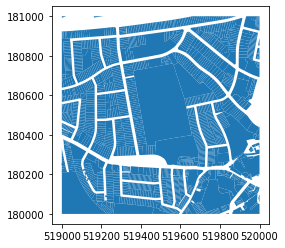

In [80]:
lrp1980.plot()

(180900, 181000)

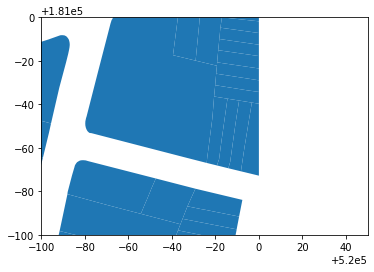

In [81]:
base = lrp1980.plot()
base.set_xlim(519900,520050)
base.set_ylim(180900,181000)

### Link gardens to buildings within same land parcel

Need to use the Land Registry parcels link shapes within the same propoerty extent because AB+ address IDs only link to the building TOID (point, polygon, and street section), but not to the other garden/shed shapes at that address.

Use these objects

- lrp1980: TQ1980 grid of Land registry property extent land parcels
- rs_gdn: defined above, the roadside garden polygons, filtered from TopographicArea
- rd_toids: residential dwelling (building) TOIDs (***these are the TOIDs of the building polygons in TopographicArea***) and point geometry from AB+ using RD class filter. The AB+ point geometry is (hopefully) already a representative point on the building shape.

In [82]:
#wrangle rd_toids, reset index, drop count col
rd = rd_toids.drop(['count'], axis=1).reset_index()

In [83]:
#wrangle rs_gdn toids, create representative point
rs_gdn = rs_gdn.copy(deep='True')
rs_gdn['geom_rep_pt'] = rs_gdn['geometry'].representative_point()

In [84]:
rs_gdn.geometry.name

'geometry'

In [85]:
rs_gdn=rs_gdn.set_geometry('geom_rep_pt')
rs_gdn.geometry.name

'geom_rep_pt'

### Plot points/shapes

Below shows the roadside garden shapes (green with white edges), their representative points (yellow) and the residential dwelling point geometry (magenta) from AB+. The land registry land parcels are the pinkish with black edges. Building shapes are not shown explicitly here, the visible parts of the land registry parcels may also include a rear garden shae as well as the building.

Immediately see there will be an alignment problem. The land registry parcels do not align exactly with the OS shapes. For example, the alley way shapes are split down the middle by the land registry parcels, but the representative point will only fall in one, yet really this space probably should be excluded, can't tell if it's shared or not.

(180000, 180200)

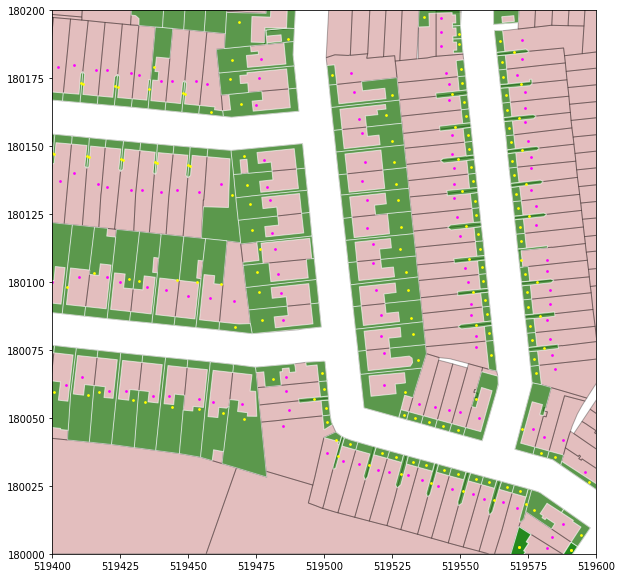

In [86]:
base = lrp1980.plot(figsize=(10,10), color = 'brown', alpha = 0.3, edgecolor = 'black')
rs_gdn = rs_gdn.set_geometry('geometry') #set geom to garden shapes
rs_gdn.plot(color = 'green', alpha = '0.6', edgecolor = 'white', ax = base)
rs_gdn=rs_gdn.set_geometry('geom_rep_pt') #set geom to garden representative point
rs_gdn.plot(color='yellow', markersize=3,ax = base)
rd.plot(color='magenta', markersize=3,ax = base)

base.set_xlim(519400,519600)
base.set_ylim(180000,180200)

(180000, 180200)

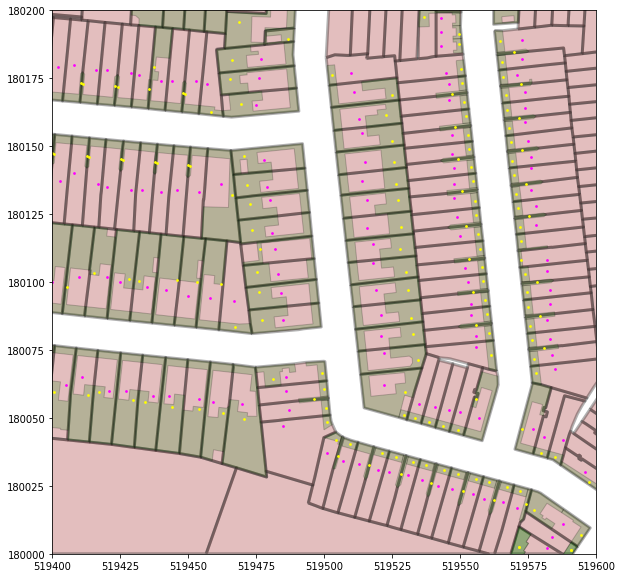

In [96]:
base = lrp1980.plot(figsize=(10,10), color = 'brown', alpha = 0.3, edgecolor = 'black', linewidth = 3)
rs_gdn = rs_gdn.set_geometry('geometry') #set geom to garden shapes
rs_gdn.plot(color = 'green', alpha = '0.2', edgecolor = 'black', ax = base)
rs_gdn=rs_gdn.set_geometry('geom_rep_pt') #set geom to garden representative point
rs_gdn.plot(color='yellow', markersize=3,ax = base)
rd.plot(color='magenta', markersize=3,ax = base)

base.set_xlim(519400,519600)
base.set_ylim(180000,180200)

### Spatial join lrp1980 to rd and rs_gdn

In [152]:
lrp1980.shape

(1708, 2)

In [158]:
#first collect the residential dwelling toids that lie within the land parcels
s1 = gpd.sjoin(lrp1980, rd, how="inner", op='contains')
#drop cols and rename
s1 = s1.drop(['index_right'], axis = 1).rename(columns={"geometry": "lrp_geom", "ta_topo_toid": "rd_poly_toid"})
#reassign geometry col
s1 = s1.set_geometry('lrp_geom')

In [155]:
s1
#contains the inspireID, the land registry parcel polygon and the topographic area toid for the 
#residential dwelling polygon

,INSPIREID,lrp_geom,rd_poly_toid
0,35014222,"POLYGON ((519258.150 180200.400, 519280.500 18...",0001000003513013
1,35014259,"POLYGON ((519281.100 180192.750, 519289.500 18...",0001000003513012
2,35014286,"POLYGON ((519258.900 180183.700, 519280.650 18...",0001000003513011
3,35014325,"POLYGON ((519259.200 180175.800, 519281.500 18...",0001000003513010
4,35014359,"POLYGON ((519259.550 180167.300, 519281.150 18...",0001000003513009
...,...,...,...
1704,34972781,"POLYGON ((519078.300 180266.400, 519088.050 18...",0001000003512861
1705,34984942,"POLYGON ((519170.419 180261.534, 519170.506 18...",0001000003512916
1706,34983747,"POLYGON ((519120.200 180285.150, 519132.300 18...",0001000003513570
1706,34983747,"POLYGON ((519120.200 180285.150, 519132.300 18...",0001000003513571


In [164]:
s1.geometry.name

'lrp_geom'

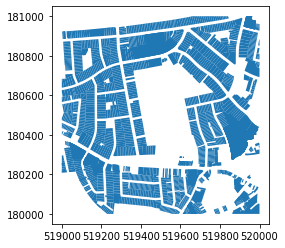

In [174]:
s1.plot()

In [170]:
#now collect the rs_gdn representative points the also lie in the land parcels
#first set geometry to the representative point
rs_gdn = rs_gdn.set_geometry('geom_rep_pt')
s2 = gpd.sjoin(s1, rd, how="inner", op='contains')

In [171]:
s2 = gpd.sjoin(s1, rs_gdn, how="inner", op='contains')

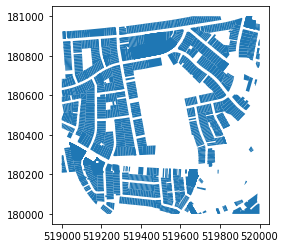

In [173]:
s2.plot()

In [176]:
s2.head()

,INSPIREID,lrp_geom,rd_poly_toid,index_right,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
0,35014222,"POLYGON ((519258.150 180200.400, 519280.500 18...",0001000003513013,3567,822601,822601,5000005125902450,10053,1,2014-05-29T00:00:00,Land,1,30.212080,2014-04-29T00:00:00,New,1,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,39.691466,30.21208,"POLYGON ((519289.500 180193.050, 519289.250 18..."
1,35014259,"POLYGON ((519281.100 180192.750, 519289.500 18...",0001000003513012,3714,822748,822748,1000001778713698,10053,1,2001-11-11T00:00:00,Land,1,33.105768,2000-05-28T00:00:00,New,1,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,40.938754,33.10575,"POLYGON ((519280.650 180184.500, 519281.400 18..."
2,35014286,"POLYGON ((519258.900 180183.700, 519280.650 18...",0001000003513011,3697,822731,822731,1000001778713632,10053,1,2001-11-11T00:00:00,Land,1,32.212240,2000-12-31T00:00:00,New,1,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,39.760809,32.21225,"POLYGON ((519293.100 180176.600, 519289.900 18..."
3,35014325,"POLYGON ((519259.200 180175.800, 519281.500 18...",0001000003513010,3685,822719,822719,1000001778714168,10053,2,2007-12-14T00:00:00,Land,1,32.438760,2007-10-09T00:00:00,Attributes,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,40.730875,32.43875,"POLYGON ((519289.900 180176.500, 519293.100 18..."
4,35014359,"POLYGON ((519259.550 180167.300, 519281.150 18...",0001000003513009,3700,822734,822734,1000001778713624,10053,2,2007-12-14T00:00:00,Land,1,31.668504,2007-10-09T00:00:00,Attributes,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,40.257578,31.66850,"POLYGON ((519293.650 180160.150, 519290.550 18..."


In [178]:
#create lookup bewteen inspire ID, building polygon TOID and roadside garden polygon TOID
lookup_rd_gdn = s2[['INSPIREID', 'rd_poly_toid', 'TOID']]

In [183]:
lookup_rd_gdn = lookup_rd_gdn.rename(columns={"TOID": "gdn_poly_toid"})
lookup_rd_gdn.head()
#This contains the INSPIREID, the residential dwelling building polygon toid and the 
#roadside garden polygon toid. The latter two from the TopographicArea OSMM layer

,INSPIREID,rd_poly_toid,gdn_poly_toid
0,35014222,0001000003513013,5000005125902450
1,35014259,0001000003513012,1000001778713698
2,35014286,0001000003513011,1000001778713632
3,35014325,0001000003513010,1000001778714168
4,35014359,0001000003513009,1000001778713624


In [213]:
lookup_rd_gdn.to_csv('../data/lookup_rd_gdn.csv', index = False)

### Check duplicates

See how many we get with count == 1. Might be easiest thing to do.

In [185]:
#check for duplicates
lookup_rd_gdn.INSPIREID.value_counts()

34988046    78
34976411    24
35058186    10
35057505    10
35046869     9
            ..
34990030     1
35065130     1
35036460     1
35009713     1
35022848     1
Name: INSPIREID, Length: 1291, dtype: int64

In [193]:
chk2 = lookup_rd_gdn.query("INSPIREID == 34988046")

### Not up to date

Comparing to AP can see that this plot is actually a new development, or block of many flats? Bit confusing.

(180000, 180400)

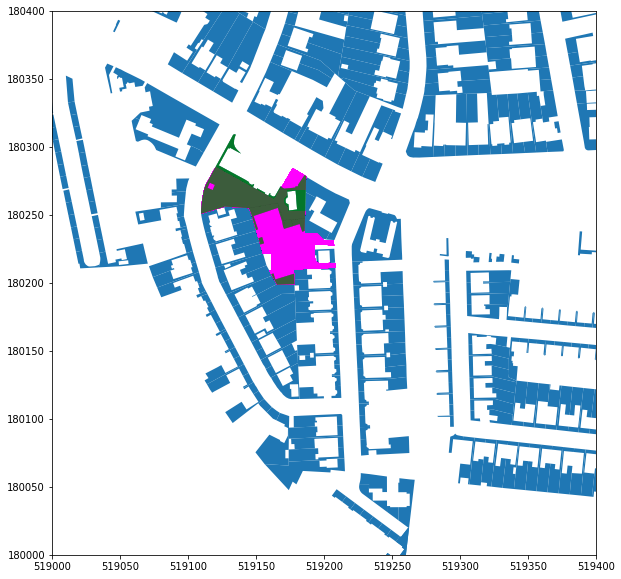

In [212]:
rs_gdn = rs_gdn.set_geometry('geometry')
base = rs_gdn.plot(figsize = (10,10))

s2 = s2.set_geometry('lrp_geom')
s2.query("INSPIREID == 34988046").plot(color = 'magenta', ax = base)

s2 = s2.set_geometry('geometry')
s2.query("INSPIREID == 34988046").plot(color = 'green', alpha = 0.1, ax = base)

base.set_xlim(519000,519400)
base.set_ylim(180000,180400)

# Archive

In [195]:
pd.crosstab(chk2.gdn_poly_toid, chk2.rd_poly_toid)

rd_poly_toid,0001000003513555,0001000003513556,0001000003513557,0001000003513558,0001000003513559,0001000003513560,0001000003513562,0001000003513563,0001000003513564,0001000003513565,0001000003513566,0001000003513567,0001000003513568
gdn_poly_toid,,,,,,,,,,,,,
1000001778713926,1,1,1,1,1,1,1,1,1,1,1,1,1
1000001778713927,1,1,1,1,1,1,1,1,1,1,1,1,1
1000001778714248,1,1,1,1,1,1,1,1,1,1,1,1,1
1000001778714258,1,1,1,1,1,1,1,1,1,1,1,1,1
1000001778811943,1,1,1,1,1,1,1,1,1,1,1,1,1
1000001778842952,1,1,1,1,1,1,1,1,1,1,1,1,1


In [66]:
#subset each string in the list to drop the first 4 characters (osgb)
toid_list = [toid[4:] for toid in toid_list] #list comprehension

In [67]:
t = pd.Series(['osgb1000006411153', 'osgb1000001654234', 'osgb5000000001654234', np.nan])
#m = t.apply(lambda x: x.str.len()==17)
t.str.replace('osgb', '000', regex=True)


0       0001000006411153
1       0001000001654234
2    0005000000001654234
3                    NaN
dtype: object

## Look at ABPlus GB file

In [ ]:
abpgb_path = "../data/ABPLUS_EPOCH76_GPKG_GB/ABPLUS_EPOCH76_GPKG_GB.gpkg"

In [ ]:
for layername in fiona.listlayers(abpgb_path):
    with fiona.open(abpgb_path, layer=layername) as src:
        print(layername, len(src))

In [ ]:
#too big to read - tried and died

## select coicindent shapes

In [ ]:
#NB holes = [] expects a list of inners, even if only 1, hence extra []
p1 = shp.geometry.Polygon(shell = [[0,0],[0,1],[1,1],[1,0]]
                     , holes = [[[0.75, 0.75],[0.25, 0.25],[0.25, 0.75],[0.75, 0.75]]])

p1

In [ ]:
p2 = shp.geometry.Polygon(shell = [[0,0],[0,1],[1,1],[1,0]]
                     , holes = [[[0.75, 0.75],[0.25, 0.25],[0.25, 0.75],[0.75, 0.75]]
                               ,[[0.9, 0.1],[0.9, 0.2],[0.8, 0.3],[0.7,0.2],[0.7,0.1]]])
p2

In [ ]:
p3 = shp.geometry.Polygon(((0,0),(10,0),(10,10),(0,10),(0,0)))
p3

In [ ]:
#order of points matters; order must be adjacent vertices, direction does not matter
#start and end points do not need to be repeated - will be automatically closed
ex = [(0, 0), (0, 10), (10, 10), (10, 0)]
inner1 = [(1, 1), (3, 1), (3, 3), (1, 3)]
inner2 = [(8, 8), (9, 8), (9, 9), (8, 9)]
inners = [inner1, inner2]

In [ ]:
p4 = shp.geometry.Polygon(ex, inners)
p4

In [ ]:
p5 = shp.geometry.Polygon(shell = ex, holes = inners)
p5

In [ ]:
p5.exterior

In [ ]:
p5.exterior.xy

In [ ]:
p5.exterior.coords.xy

In [ ]:
#convert coords sequence to list, includes repeated verex
list(p5.exterior.coords)

In [ ]:
poly.geom_type

In [ ]:
poly - poly.representative_point()

In [ ]:
plt.plot(poly.exterior.xy)

In [ ]:
poly.bounds

In [ ]:
poly.length

In [ ]:
poly.area

In [ ]:
poly.distance(poly.representative_point())

In [ ]:
#class Polygon(shell, holes = [])
#even if only 1 hole, holes expects a list of holes, hence extra []
shp.geometry.Polygon(shell = [(0, 0), (0, 10), (10, 10), (10, 0)], holes = [[(1, 1), (3, 1), (3, 3), (1, 3)]])

### create coincident polygons

In [ ]:
a = shp.geometry.Polygon(shell = [[0,0], [0,1], [1,1]])
b = shp.geometry.Polygon(shell = [[0,0], [1,0], [1,1]])

In [ ]:
c = shp.geometry.Point([0.5, 0.5]) #on diagonal edge
d = shp.geometry.Point([0.25, 0.5]) #on diagonal edge

In [ ]:
a

In [ ]:
b

### within

In [ ]:
#check if point is within a polygon
d.within(a)

### contains

In [ ]:
#check if a polygon contains a point
a.contains(d)

### intersects

In [ ]:
#two polygons sharing an entire edge intersect
a.intersects(b)

In [ ]:
#a single point intersects on the edge of a polygon
c.intersects(a)

In [ ]:
#or vice versa
a.intersects(c)